Validation day is:  2024-07-01 00:00:00
The model output has the following 1 parameters with shape (N_time, N_lat, N_lon): 
TEC , shape  (96, 37, 73)
File '/Users/mevans/Downloads/Jason_Data/jason_manifest.txt' already exists. Checking for updates.
Last recorded data: cycle: 511, timestamp: 2025-05-13 01:04:23
1 total cycles will be scanned up to/including cycle 511)


Processing cycles: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


No new files to add. Manifest is up to date.

Filtering for overlap with user-specified time window:2024-07-01 00:00:00 to 2024-07-01 23:45:00.
Searching 174807 URLs from manifest.


Filtering URLs: 100%|██████████| 174807/174807 [00:03<00:00, 51338.00file/s]


Found 26 matching files.

Processing Jason TEC data from 26 files.


Jason file progress: 100%|██████████| 26/26 [02:01<00:00,  4.67s/file]


Saving Raw Jason TEC data to: '/Users/mevans/Downloads/Jason_Data/Jason_TEC_raw_PyIRI_Validation.p'
G has shape [N_obs, N_time, N_lat, N_lon] =  (58130, 96, 37, 73)
key=  TEC
Figure Residual Map is saved at:  /Users/mevans/Downloads/Jason_Images/TEC_Residuals_Map.pdf
Figure Residuals is saved at:  /Users/mevans/Downloads/Jason_Images/TEC_Residuals.pdf


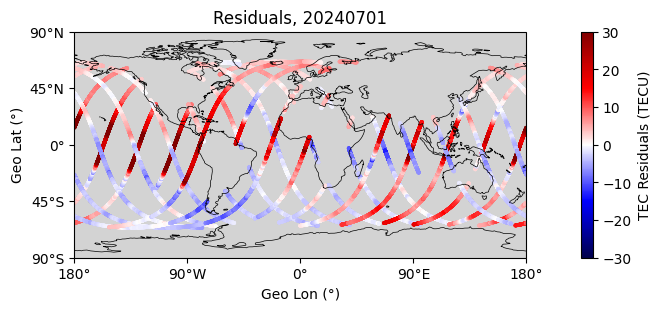

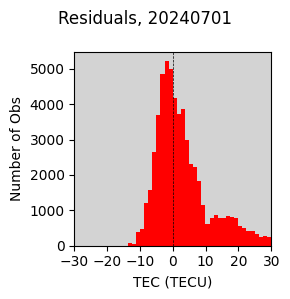

In [ ]:

import PyVALION
import PyIRI
import datetime
import numpy as np
import pandas as pd
import os
import pickle


# In this example, we will create a model output using the PyIRI module
# You can provide your own model output for the validation

# Folder where the downloaded Jason TEC data will be saved
# This folder should also hold a local copy of jason_manifest.txt
data_save_dir = '/Users/mevans/Downloads/Jason_Data/'

# Folder where the residual images will be saved
save_img_dir = '/Users/mevans/Downloads/Jason_Images/'

# Name of the validation run
name_run = 'PyIRI_Validation'

# Select the desired day for validation
year = 2024
month = 7
day = 1

# Create a datetime object for the selected day
dtime = datetime.datetime(year, month, day)
print('Validation day is: ', dtime)

# Create an array for the model's time resolution
# In this example, we use 15-minute resolution
atime = pd.to_datetime(np.arange(dtime,
                                 dtime + datetime.timedelta(days=1),
                                 datetime.timedelta(minutes=15)))

# Convert atime to an array of decimal hours
aUT = atime.hour + atime.minute / 60. + atime.second / 3600.

# Provide the F10.7 value for this day
# You can look it up at OMNIWeb: https://omniweb.gsfc.nasa.gov/form/dx1.html
F107 = 174.

# Create a model grid
ddeg = 5.
alon = np.arange(-180, 180 + ddeg, ddeg)
alat = np.arange(-90, 90 + ddeg, ddeg)
alon_reg_2d, alat_reg_2d = np.meshgrid(alon, alat)
aalt = np.arange(100, 1000, 10)

# Sizes of the grid
N_lon = alon.size
N_lat = alat.size
N_time = aUT.size
N_alt = aalt.size

# Flatten grid arrays
alon_reg = np.reshape(alon_reg_2d, alon_reg_2d.size)
alat_reg = np.reshape(alat_reg_2d, alon_reg_2d.size)

# Run PyIRI
_, _, _, _, _, _, den = PyIRI.main_library.IRI_density_1day(dtime.year,
                                                             dtime.month,
                                                             dtime.day,
                                                             aUT,
                                                             alon_reg,
                                                             alat_reg,
                                                             aalt,
                                                             F107,
                                                             PyIRI.coeff_dir,
                                                             ccir_or_ursi=1)

# Compute TEC from PyIRI data
TEC_IRI = PyIRI.main_library.edp_to_vtec(den,
                                         aalt,
                                         min_alt=0.0,
                                         max_alt=202000.0)

# Record the model outputs into a dictionary
# When using your own model, match the format to this dictionary
model = {}
model['TEC'] = np.reshape(TEC_IRI, (N_time, N_lat, N_lon))

# A dictionary to hold the units of the model outputs
units = {}
units['TEC'] = 'TECU'

print('The model output has the following', len(model),
      'parameters with shape (N_time, N_lat, N_lon): ')
for key in model:
    print(key, ', shape ', model[key].shape)

# Download all raw Jason TEC data for the validation time
# If you need to exclude certain satellites, modify the sat_names array
sat_names = np.array(["JA2", "JA3"])
raw_data =  PyVALION.library.download_Jason_TEC(atime[0],
                                                atime[-1],
                                                data_save_dir,
                                                name_run=name_run,
                                                save_data_option=True,
                                                sat_names=sat_names)

# Create a forward operator for the Jason TEC dataset using the given model
obs_data, obs_units, G = PyVALION.library.find_Jason_G_and_y(atime,
                                                             alon,
                                                             alat,
                                                             raw_data)

# Find residuals between the observed data and model forecast
model_data, residuals, model_units = PyVALION.library.find_Jason_residuals(
    model, G, obs_data, units)

# Create a map showing the residuals between model and data observations
PyVALION.plotting.plot_TEC_residuals_map(obs_data['lat'],
                                         obs_data['lon'],
                                         residuals,
                                         atime[0],
                                         save_option=True,
                                         save_dir=save_img_dir,
                                         plot_name='TEC_Residuals_Map')

# Create a histogram of residuals between model data and observations
PyVALION.plotting.plot_TEC_residuals_histogram(residuals,
                                               model_units,
                                               atime[0],
                                               save_option=True,
                                               save_dir=save_img_dir,
                                               plot_name='TEC_Residuals')
